In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import copy
import datetime

In [3]:
with open('MLTempDataset1.csv', 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    temp_list = []
    dataset = []
    date_list = []

    with open('time_series_temp.csv', 'w') as temp_series:
        fieldnames = ['Datetime', 'Hourly_Temp']
        
        csv_writer = csv.DictWriter(temp_series, fieldnames=fieldnames)
        csv_writer.writeheader()

        for line in csv_reader:
            dataset.append(line)
            temp_list.append(float(line['Hourly_Temp']))
            date_list.append(datetime.datetime.strptime(line['Datetime'], '%Y-%m-%d %H:%M:%S'))
            del line['']
            csv_writer.writerow(line)
        
    
    

In [4]:
data = []
for dictionary in dataset:
    data.append(list(dictionary.values()))
data_arr = np.array(data)
print(data_arr)

[['2022-01-04 00:00:00' '20.867']
 ['2022-01-04 01:00:00' '21.0']
 ['2022-01-04 02:00:00' '20.867']
 ...
 ['2022-10-24 21:00:00' '24.6']
 ['2022-10-24 22:00:00' '23.986']
 ['2022-10-24 23:00:00' '23.383']]


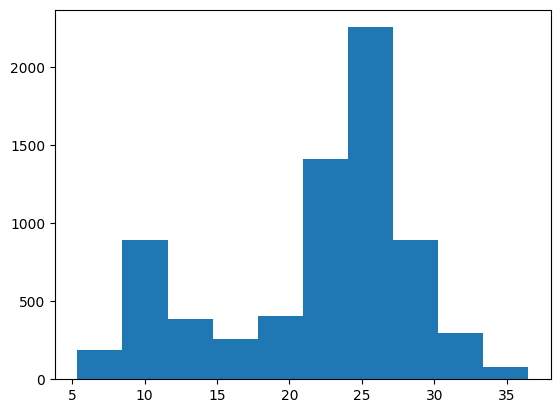

In [5]:
sorted_temp_arr = np.sort(temp_list)
plt.hist(sorted_temp_arr, bins=10)
plt.show()

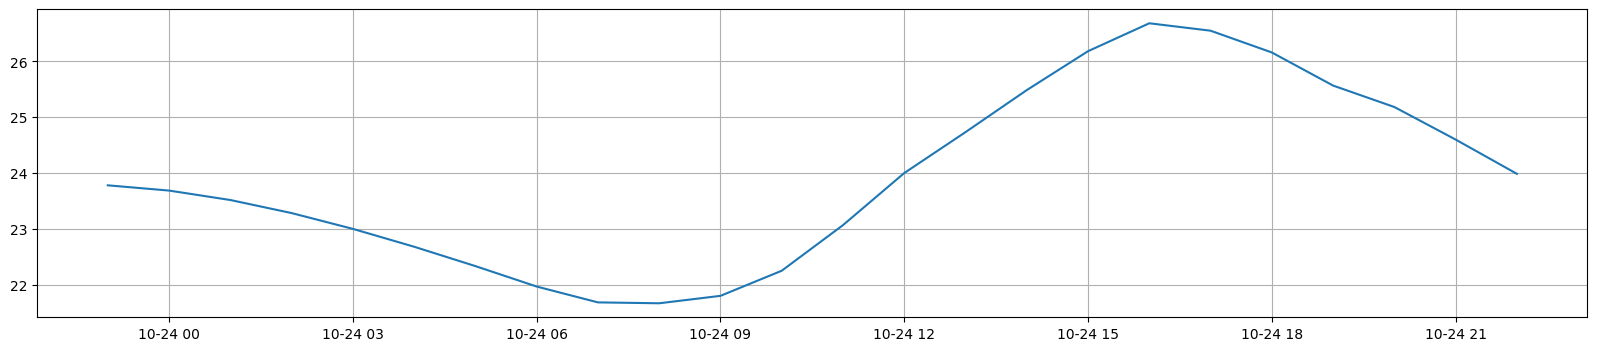

In [6]:
data_x = date_list[7031:7055]
data_y = temp_list[7031:7055]
plt.figure(figsize=(20,4))
plt.plot(data_x, data_y)
plt.grid()
plt.show()

In [7]:
#Поиск анамалий через правило трех сигм
temp_list_3sigma = np.array(data)

avg_temp = np.average(sorted_temp_arr)
std_temp = np.std(sorted_temp_arr)

min_temp = avg_temp - 2 * std_temp
max_temp = avg_temp + 2 * std_temp
k = 0
c = 0

for line in temp_list_3sigma:
    if (float(line[1]) > max_temp) or (float(line[1]) < min_temp):
        temp_list_3sigma[k][1] = None
        c += 1
    k += 1

print("Кол-во выбросов:", c, "из", len(temp_list))

Кол-во выбросов: 182 из 7056


In [8]:
#Заметим, что подобное количество выбросов, скорее всего неадекватно, а если мы взглянем на гистограммаму выше, то и вовсе становится
#ясно, что подобные температуры существовать могут, так что, если в этом датасете и есть аномалии, то они возможны лишь в случае, если
#температура неожиданно возросла или уменьшилась в несколько раз, что можно объяснить неверной работы термомтера, следовательно данный
#метод поиска выбросов, навряд ли дает нам четкую картину о их существовании

In [9]:
#Поиск анамалий через правило n сигм
temp_list_nsigma = np.array(data)

avg_temp = np.average(sorted_temp_arr)
std_temp = np.std(sorted_temp_arr)

min_temp = avg_temp - 3 * std_temp
max_temp = avg_temp + 3 * std_temp
k = 0
c = 0

for line in temp_list_nsigma:
    if (float(line[1]) > max_temp) or (float(line[1]) < min_temp):
        temp_list_nsigma[k][1] = None
        c += 1
    k += 1

print("Кол-во выбросов:", c, "из", len(temp_list))

Кол-во выбросов: 0 из 7056


In [22]:
#Прогнозирование при помощи экспоненциального сглаживания
last_temp_list = []
last_temp_list = np.array(data[:-13:-1])
last_temp_list = last_temp_list[::-1]
forecast_temp_list = np.array(last_temp_list)

a = 0.9

for i in range(11):
    temp = float(last_temp_list[i][1])
    temp_forecast = float(forecast_temp_list[i][1])
    next_temp_forecast = a * temp + (1 - a) * temp_forecast
    forecast_temp_list[i+1][1] = next_temp_forecast


    



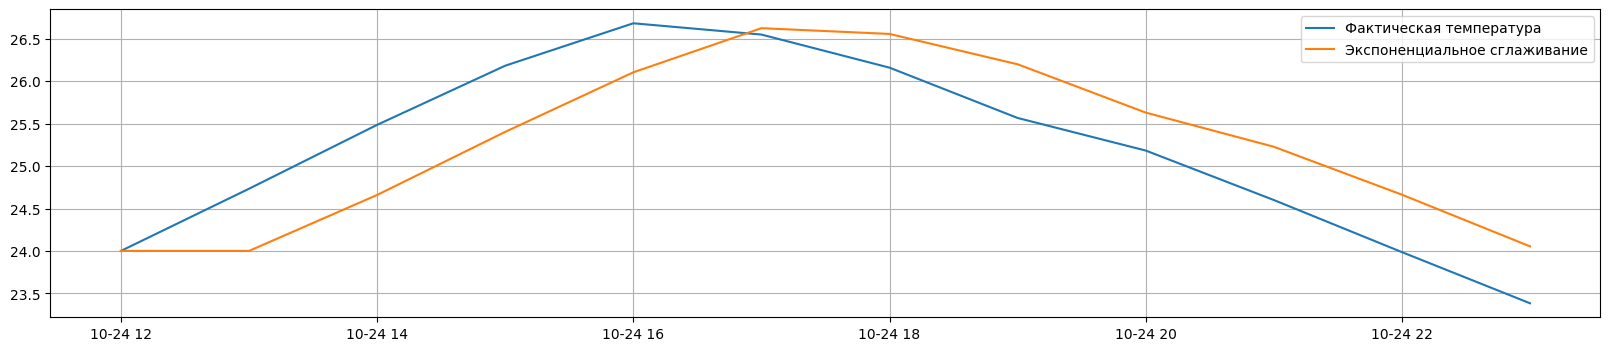

In [28]:
#Cравнение прогноза и реальности
data_x = date_list[7044:7056]
data_y = temp_list[7044:7056]
data_y_forecast = []

for line in forecast_temp_list:
    data_y_forecast.append(float(line[1]))

plt.figure(figsize=(20,4))
plt.plot(data_x, data_y, label='Фактическая температура')
plt.plot(data_x, data_y_forecast, label='Экспоненциальное сглаживание')
plt.legend()
plt.grid()
plt.show()
    

In [76]:
#Прогнозирование при помощи двойного экспоненциального сглаживания
# • Сглаживание уровня:
#         S(t) = α * Y(t) + (1 - α) * (S(t-1) + b(t-1))   
# • Сглаживание тренда:
#         b(t) = β * (S(t) - S(t-1)) + (1 - β) * b(t-1) 
# • Прогноз:
#         F(t+1) = S(t) + b(t)

last_temp_list = []
last_temp_list = np.array(data[:-13:-1])
last_temp_list = last_temp_list[::-1]
forecast2_temp_list = np.array(last_temp_list)
trend_list = [float(forecast2_temp_list[1][1]) - float(forecast2_temp_list[0][1])]

a = 0.6
b = 0.7

for i in range(11):
    temp = float(last_temp_list[i][1])
    temp_forecast = float(forecast2_temp_list[i][1])
    trend_val = trend_list[i]

    next_temp_forecast = a * temp + (1 - a) * (temp_forecast + trend_val)
    next_trend_val = b * (next_temp_forecast - temp_forecast) + (1 - b) * trend_val

    trend_list.append(next_trend_val)
    forecast2_temp_list[i+1][1] = next_temp_forecast


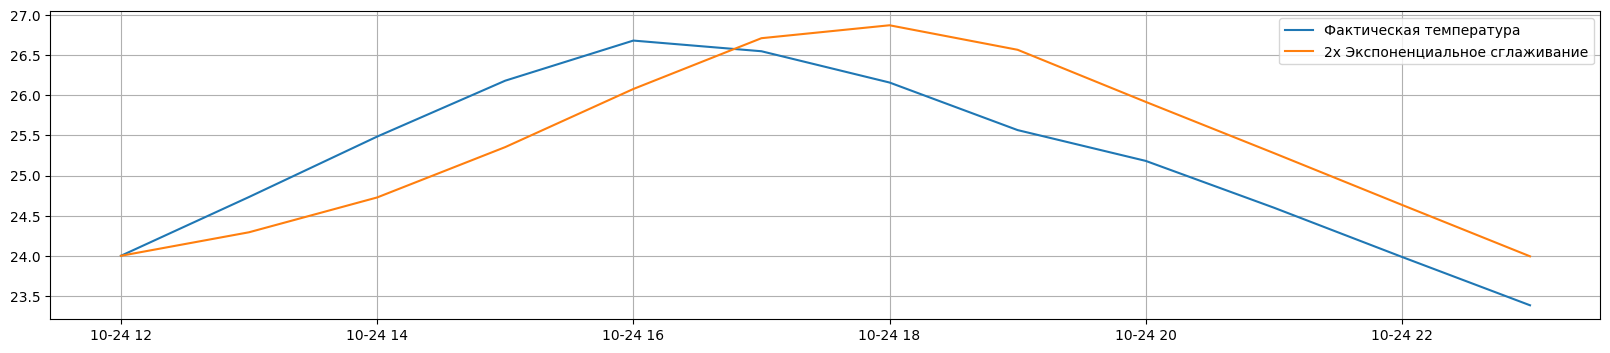

In [77]:
#Cравнение прогноза и реальности
data_x = date_list[7044:7056]
data_y = temp_list[7044:7056]
data_y_forecast = []

for line in forecast2_temp_list:
    data_y_forecast.append(float(line[1]))

plt.figure(figsize=(20,4))
plt.plot(data_x, data_y, label='Фактическая температура')
plt.plot(data_x, data_y_forecast, label='2x Экспоненциальное сглаживание')
plt.legend()
plt.grid()
plt.show()

In [96]:
#чисто мой интерес
last_temp_list = []
last_temp_list = np.array(data[:-168:-1])
last_temp_list = last_temp_list[::-1]
forecast2_temp_list = np.array(last_temp_list)
trend_list = [float(forecast2_temp_list[1][1]) - float(forecast2_temp_list[0][1])]

a = 0.6
b = 0.7

for i in range(166):
    temp = float(last_temp_list[i][1])
    temp_forecast = float(forecast2_temp_list[i][1])
    trend_val = trend_list[i]

    next_temp_forecast = a * temp + (1 - a) * (temp_forecast + trend_val)
    next_trend_val = b * (next_temp_forecast - temp_forecast) + (1 - b) * trend_val

    trend_list.append(next_trend_val)
    forecast2_temp_list[i+1][1] = next_temp_forecast


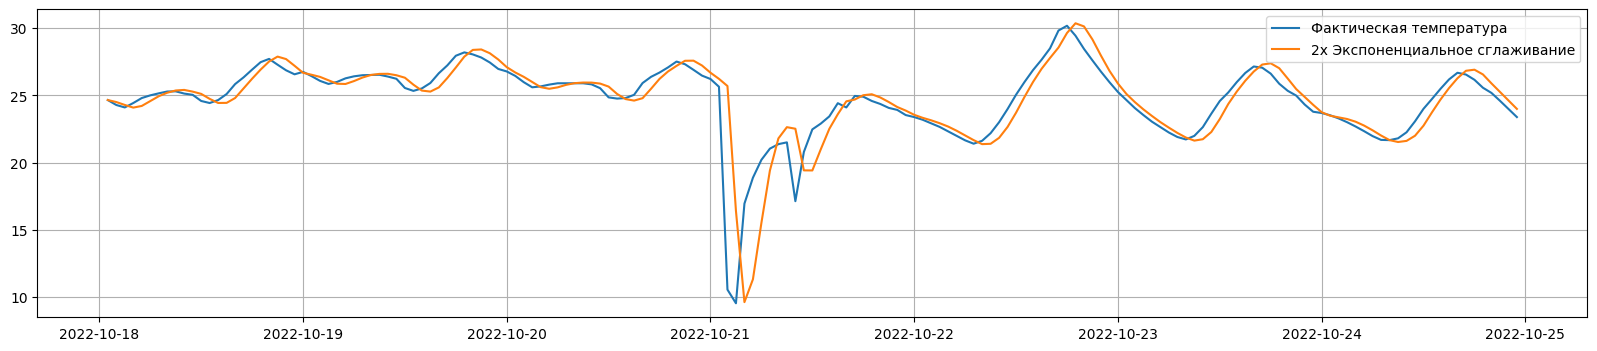

In [97]:
#Cравнение прогноза и реальности
data_x = date_list[6889:7056]
data_y = temp_list[6889:7056]
data_y_forecast = []

for line in forecast2_temp_list:
    data_y_forecast.append(float(line[1]))

plt.figure(figsize=(20,4))
plt.plot(data_x, data_y, label='Фактическая температура')
plt.plot(data_x, data_y_forecast, label='2x Экспоненциальное сглаживание')
plt.legend()
plt.grid()
plt.show()